## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Process two videos correctly highlighting the lane, lane curvature and vehicle position.


In [1]:
# load needed packages 
import numpy as np 
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import h5py
%matplotlib inline

In [2]:
# set global parameters
output_dir = 'output_images'
param_file = os.path.join(output_dir,'param.h5')

global left_fit
global right_fit
global obj_points
global img_points
global use_red_filter
global use_prev_fit

left_fit = None
right_fit = None
obj_points = None
img_points = None
use_red_filter = True
use_prev_fit = True
prev_fit_w = 1.0

### Camera Calibration using chessboard images

Compute the camera calibration matrix and distortion coefficients from a set of chessboard images.


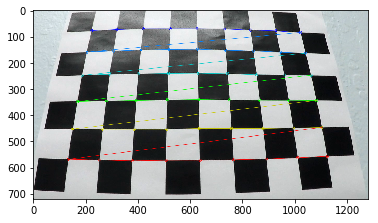

In [3]:
def calibrate_camera():
    # Arrays to store object points and image points from all the images.
    obj_points = [] # 3d points in real world space
    img_points = [] # 2d points in image plane.

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # process the chessboard images to obtain the object point and image points.
    file_names = glob.glob('camera_cal/calibration*.jpg')
    #print(file_names)
    fig = plt.figure(num=1)
    
    i_sp = 13
    for (i,file_name) in enumerate(file_names):
        # read in the image
        img = cv2.imread(file_name)

        # conver the image to gray
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            obj_points.append(objp)
            img_points.append(corners)

            # Draw and display the corners
            if (i == i_sp):
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imshow(img)
            #print(objp.shape,corners.shape)
                
    return obj_points,img_points
    
obj_points,img_points = calibrate_camera()  


In [4]:
# function to correct an image for distortions using object_points and image points.
def undistort_image(img,obj_points,img_points):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (img.shape[1],img.shape[0]), None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

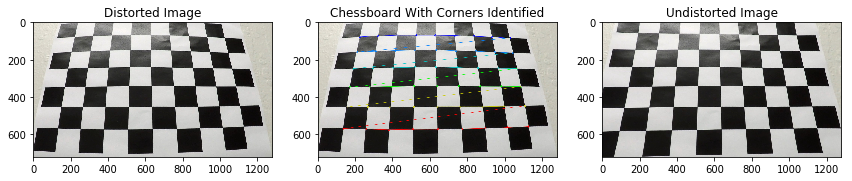

In [5]:
# check that this worked on a chess board iamges
file_name = 'camera_cal/calibration3.jpg'

# read in the image.
img = cv2.imread(file_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# draw the chess board corners
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
img_wcc = img.copy()
img_wcc = cv2.drawChessboardCorners(img_wcc, (9,6), corners, ret)

undst = undistort_image(img,obj_points,img_points)

plt.figure(num=1)
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(img)
ax[0].set_title("Distorted Image")
ax[1].imshow(img_wcc)
ax[1].set_title("Chessboard With Corners Identified")
ax[2].imshow(undst)
ax[2].set_title("Undistorted Image")
plt.tight_layout()

fig.savefig(os.path.join(output_dir,"chessboard.jpg"))


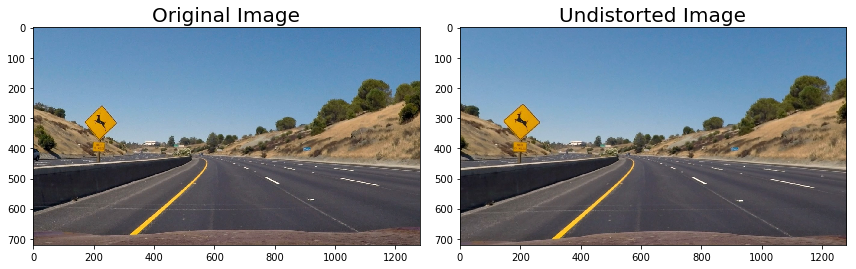

In [6]:
# Process the following test images and remove the distortions using the 
# above computed obj_points and img_points.

test_files = glob.glob('test_images/test*.jpg')

i_sp = 0
i_list = [1] #0,1,4]
n_xsp = len(i_list)
n_ysp = 2
fig = plt.figure(num=1, figsize=(12,4))  #figsize=(10,10))

for i,test_file in enumerate(test_files):
    # read in the file
    #print(test_file)
    img = cv2.imread(test_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Correct image distortions
    dst = undistort_image(img,obj_points,img_points)

    # display the original and undistorted image
    if i in i_list:
        ax = fig.add_subplot(n_xsp,n_ysp,i_sp+1)
        ax.set_title('Original Image', fontsize=20)
        plt.imshow(img)
    
        ax = fig.add_subplot(n_xsp,n_ysp,i_sp+2)
        ax.set_title('Undistorted Image', fontsize=20)
        plt.imshow(dst)
        
        plt.tight_layout()
        
        i_sp += 2
        
fig.savefig(os.path.join(output_dir,"undist_test_images.jpg"))
    

### Create a binary image that identifies edges from color transforms and gradients.

An images can be transformed from the RGB (Red, Green, Blue) values to HLS (Hue, Saturation, Lightness) values.  The HLS values are better for identifing lines.  

The Sobel filter can be applied to the images or aspects of the image to clearly detect edges.

In [7]:
# Edit this function to create your own pipeline.
def get_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100), r_thresh=(195, 255)):
    global use_red_filter

    img = np.copy(img)
    
    r_channel = img[:,:,0].copy()
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # convert the image to gray scale after selecting only the red spectrum
    if (use_red_filter):
        red_lb = np.array([195,50,50])
        #red_lb = np.array([210,50,50])
        red_ub = np.array([255,255,255])
        mask = cv2.inRange(img,red_lb,red_ub)
        img = cv2.bitwise_and(img.copy(),img.copy(),mask=mask)
    
    # Convert to HLS color space and separate out the channels
    hls = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # combine the x gradient and color channels
    color_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #color_binary[((r_binary == 1) & (s_binary == 1)) | (sxbinary == 1)] = 1
    
    return color_binary

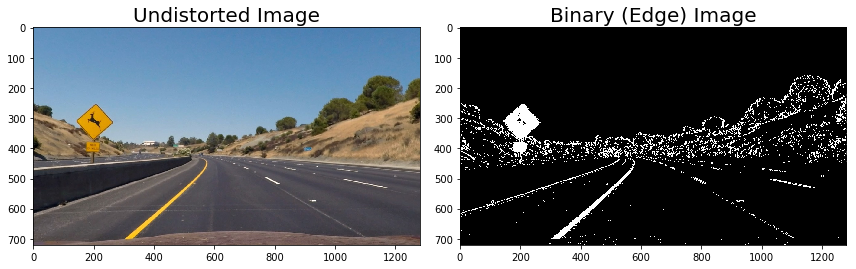

In [8]:
# Process the following test images, remove the distortions, 
# and then compute the binary thresholded image that reveals the edges.

test_files = glob.glob('test_images/t*.jpg')
test_files = test_files[:]

i_sp = 0
i_list = [1] #[0,1,2,3]
n_xsp = len(i_list) #len(test_files)
n_ysp = 2
fig = plt.figure(num=1, figsize=(12,4))  #figsize=(10,10))
#fig = plt.figure(num=1, figsize=(10,10))

use_red_filter = False

for i,test_file in enumerate(test_files):
    # read in the file
    #print(test_file)
    img = cv2.imread(test_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Correct image distortions and get the binary image
    undst_img = undistort_image(img,obj_points,img_points)
    bin_img = get_binary_image(undst_img)
    
    # display the original and undistorted image
    if i in i_list:
        ax = fig.add_subplot(n_xsp,n_ysp,i_sp+1)
        ax.set_title('Undistorted Image', fontsize=20)
        plt.imshow(undst_img)
    
        ax = fig.add_subplot(n_xsp,n_ysp,i_sp+2)
        ax.set_title('Binary (Edge) Image', fontsize=20)
        plt.imshow(bin_img)

        plt.tight_layout()
    
        i_sp += 2
        
fig.savefig(os.path.join(output_dir,"binary_edge_images_red.jpg"))


### Perpsective Transform of binary image (Create a "birds-eye-view")

Define fixed points that will be used to transform the binary image to a birds-eye-view image that will be used to lane detection.  


In [9]:
# run a perspective transform of an image to get the "birds-eye-view" (bev)
#bev_img,bev_M,pts_src,pts_dst,btm_offset = get_bev_image(bin_img,460,440,15,60.0,2)
def get_bev_image(img,vert_min=460,bottom_halfwidth=440,bottom_offset=15,top_halfwidth=60,top_offset=2.):       
    # find the points for the birds-eye view (bev) transformation  
    (vert_max,horz_max) = (img.shape[0],img.shape[1])
    horz_mid = 0.5*horz_max;
    offset = 320
    
    top_mid = horz_mid+top_offset
    btm_mid = horz_mid+bottom_offset
    btm_halfwidth = bottom_halfwidth
    #print(bottom_offset*top_halfwidth/bottom_halfwidth)

    pts_src = np.array([[(btm_mid-btm_halfwidth-1,vert_max-1),(top_mid-top_halfwidth-1,vert_min-1), \
                        (top_mid+top_halfwidth-1,vert_min-1),(btm_mid+btm_halfwidth-1,vert_max-1)]],dtype=np.float32)
    pts_dst = np.array([[(offset-1,vert_max-1), (offset-1,0), \
                        (horz_max-offset-1,0), (horz_max-offset-1,vert_max-1)]],dtype=np.float32)
    #print(pts_src,pts_dst)
    
    bev_M = cv2.getPerspectiveTransform(pts_src,pts_dst)
    bev_img = cv2.warpPerspective(img,bev_M,(horz_max,vert_max))
    
    btm_offset = bottom_offset*((2*bottom_halfwidth)/(horz_max-2*offset))
    
    return bev_img,bev_M,pts_src,pts_dst,btm_offset

In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

test_images\straight_lines1.jpg
test_images\straight_lines2.jpg


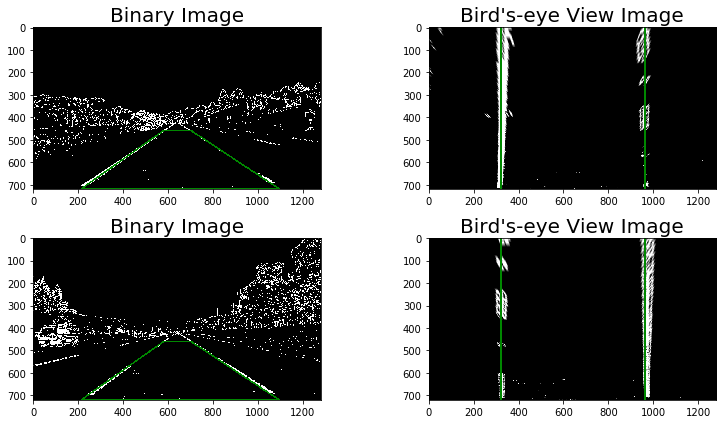

In [11]:
# verify the birds-eye view perspective transform
test_files = glob.glob('test_images/s*.jpg')

n_xsp = len(test_files)
n_ysp = 2
i_sp = 0
i_list = range(0,len(test_files))
fig = plt.figure(num=1, figsize=(12,6))

for i,test_file in enumerate(test_files):
    # read in the file
    print(test_file)
    img = cv2.imread(test_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Do camera calibration given object points and image points
    undst_img = undistort_image(img,obj_points,img_points)
    bin_img = get_binary_image(undst_img)

    # Get the birds-eye-view of the 
    #bev_img,bev_M,pts_src,pts_dst,btm_offset = get_bev_image(bin_img,460,440,15,60.0,2)
    bev_img,bev_M,pts_src,pts_dst,btm_offset = get_bev_image(bin_img,460,440,15,60.0,2)
    # add shift from center.

    # display the original and undistorted image
    if i in i_list:
        # Plot the lines from the transform
        trap_lines = np.array([[np.hstack([pts_src[0][0],pts_src[0][1]]),np.hstack([pts_src[0][1],pts_src[0][2]]),\
                                np.hstack([pts_src[0][2],pts_src[0][3]]),np.hstack([pts_src[0][3],pts_src[0][0]])]])
        draw_lines(bin_img, trap_lines, [0,120,0], thickness=5)
        
        offset = 320
        v_max,h_max = bev_img.shape[0:2]
        bev_lines  = np.array([[[offset,0,offset,v_max],[h_max-offset,0,h_max-offset,v_max]]])
        draw_lines(bev_img, bev_lines, [0,120,0], thickness=10)
          
        ax = fig.add_subplot(n_xsp,n_ysp,i_sp+1)
        ax.set_title('Binary Image', fontsize=20)
        plt.imshow(bin_img)
    
        ax = fig.add_subplot(n_xsp,n_ysp,i_sp+2)
        ax.set_title("Bird's-eye View Image", fontsize=20)
        plt.imshow(bev_img)

        plt.tight_layout()
        
        i_sp += 2

fig.savefig(os.path.join(output_dir,"bev_images.jpg"))

### Find lanes using straight line test images.  

Using the perspective transform of the binary image, then following will
* Detect the lanes and fit a quadratic line through the lane pixels.
* Determine the curvature of the lane
* Calculate the vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.

In [12]:
# this function applies a window mask 
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-0.5*width)):min(int(center+0.5*width),img_ref.shape[1])] = 1
    return output

# this function finds the window centroids
def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_conv = np.convolve(window,l_sum)
    l_center = np.argmax(l_conv)
    if ((l_center == 0) and (l_conv[l_center] == 0)):
        l_center = int(window_width/2)        
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_conv = np.convolve(window,r_sum)
    r_center = np.argmax(r_conv)
    if ((r_center == 0) and (r_conv[r_center] == 0)):
        r_center = int(window_width/2)
    r_center += int(image.shape[1]/2)
    #print(l_center,r_center)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center-margin,0))
        l_max_index = int(min(l_center+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])
        if ((l_center == 0) and (conv_signal[l_min_index+l_center] == 0)):
            l_center = int(window_width/2)
        l_center += l_min_index
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center-margin,0))
        r_max_index = int(min(r_center+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])
        if ((r_center == 0) and (conv_signal[r_min_index+r_center] == 0)):
            r_center = int(window_width/2)
        r_center += r_min_index
        #print(l_center,r_center)
    
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [13]:
# this function finds the lanes from the binary birds-eye-view (bev) image
def get_lane_fits(bev_img, left_fit, right_fit, center_shift=0):
    global use_prev_fit
    global prev_fit_w
    
    window_width = 200 #300 #200 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin_w = 100 #150 #100       # margin for the window boxes
    margin_f = 0.5*margin_w   # margin for the previous fit
    n_min_fit = 100 #250
    
    bev = cv2.cvtColor(bev_img.astype(np.float32),cv2.COLOR_RGB2GRAY)  
    (y_max,x_max) = (bev.shape[0],bev.shape[1])
    
    w_mid = 0.5 #2./3. #0.75 #2./y_max # 0.5
    
    # fit the lanes 
    nonzero = bev.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx = np.empty(0)
    lefty = np.empty(0)
    leftw = np.empty(0)
    rightx = np.empty(0)
    righty = np.empty(0)
    rightw = np.empty(0)
    
    if ((left_fit is not None) and (right_fit is not None)):
        #find the edge pixels within +/- margin of the previous fit line
        left_prevx = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
        left_lane_inds = ((nonzerox >= (left_prevx - margin_f)) 
                          & (nonzerox <= (left_prevx + margin_f))
                          & (nonzerox < (0.5*x_max-1)))
        right_prevx = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
        right_lane_inds = ((nonzerox >= (right_prevx - margin_f)) 
                           & (nonzerox <= (right_prevx + margin_f))
                           & (nonzerox > (0.5*x_max-1)))
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        #print(len(leftx),len(lefty),len(rightx),len(righty))
        
        leftw = np.minimum(1.0,lefty.copy().astype(np.float32) / (w_mid*y_max-1))
        #leftw = 0.5*(np.minimum(1.0,lefty.copy().astype(np.float32) / (w_mid*y_max-1)))
        #left_prevx = left_fit[0]*(lefty**2) + left_fit[1]*lefty + left_fit[2]
        #leftw += 0.5*(np.minimum(1.0,np.abs(leftx-left_prevx)/(w_mid*margin)))
        rightw = np.minimum(1.0,righty.copy().astype(np.float32) / (w_mid*y_max-1))
        #rightw = 0.5*(np.minimum(1.0,righty.copy().astype(np.float32) / (w_mid*y_max-1)))
        #right_prevx = right_fit[0]*(righty**2) + right_fit[1]*righty + right_fit[2]
        #rightw += 0.5*(np.minimum(1.0,np.abs(rightx-right_prevx)/(w_mid*margin)))
        
        # use points from the previous fit in a moving average type approach.
        if (use_prev_fit) :
            #n_y_s = np.maximum(0.5*y_max,np.minimum(2*y_max,prev_fit_w*len(lefty)))
            n_y_s = np.maximum(y_max,prev_fit_w*len(lefty))
            y_s = np.linspace(0, y_max-1, int(n_y_s))
            #print(len(y_s))
            w_s = prev_fit_w*np.minimum(1.0,(y_s.copy().astype(np.float32)) / (w_mid*y_max-1))
            left_fitx_s = left_fit[0]*y_s**2 + left_fit[1]*y_s + left_fit[2]
            
            leftx = np.append(leftx,left_fitx_s)
            lefty = np.append(lefty,y_s)
            leftw = np.append(leftw,w_s)
            
            #n_y_s = np.maximum(0.5*y_max,np.minimum(2*y_max,prev_fit_w*len(righty)))
            n_y_s = np.maximum(y_max,prev_fit_w*len(righty))
            y_s = np.linspace(0, y_max-1, int(n_y_s))
            w_s = prev_fit_w*np.minimum(1.0,(y_s.copy().astype(np.float32)) / (w_mid*y_max-1))
            right_fitx_s = right_fit[0]*y_s**2 + right_fit[1]*y_s + right_fit[2]
            
            rightx = np.append(rightx,right_fitx_s)
            righty = np.append(righty,y_s)
            rightw = np.append(rightw,w_s)
            
    else:
        #print('front centroids')
        # identify the peak of the edge pixels on both the right and left sides for each verticle slice.
        window_centroids = find_window_centroids(bev, window_width, window_height, margin_w)
        # go through the windows and look for eligible fitting pixels
        if len(window_centroids) > 0:  
            for k in range(0,len(window_centroids)):
                 #print(y_max-(k+1)*window_height,y_max-k*window_height)
                left_center = window_centroids[k][0]
                left_lane_inds  = ((nonzeroy >= (y_max-(k+1)*window_height))
                                    & (nonzeroy < (y_max-k*window_height))
                                    & (nonzerox >= (left_center-0.5*window_width))
                                    & (nonzerox <= (left_center+0.5*window_width)))
                right_center = window_centroids[k][1]
                right_lane_inds = ((nonzeroy >= (y_max-(k+1)*window_height))
                                    & (nonzeroy < (y_max-k*window_height))
                                    & (nonzerox >= (right_center-0.5*window_width))
                                    & (nonzerox <= (right_center+0.5*window_width)))
                leftx = np.append(leftx,nonzerox[left_lane_inds])
                lefty = np.append(lefty,nonzeroy[left_lane_inds])
                rightx = np.append(rightx,nonzerox[right_lane_inds])
                righty = np.append(righty,nonzeroy[right_lane_inds])
        #print(len(leftx),len(lefty),len(rightx),len(righty))
        leftw = np.minimum(1.0,lefty.copy().astype(np.float32) / (w_mid*y_max-1))
        rightw = np.minimum(1.0,righty.copy().astype(np.float32) / (w_mid*y_max-1))
                
    # Fit a second order polynomial to each
    #if (len(leftw) == 0):
    #    leftw = lefty.copy().astype(np.float32)
    #    leftw /= (0.5*y_max-1)
    #    leftw[(leftw > 1).nonzero()] = 1
    #    rightw = righty.copy().astype(np.float32)
    #    rightw /= (0.5*y_max-1)
    #    rightw[(rightw > 1).nonzero()] = 1

    # check for sufficient fit points, and whether the first fit attempt return reasonable values 
    # for the mid to lower part of the image which is closest to the car.
    left_ok = 0
    if (len(lefty) > n_min_fit):
        left_fit_c = np.polyfit(lefty, leftx, 2, w=leftw)
        c_y = np.array([int(0.5*y_max-1),y_max-1])
        left_fit_cx = left_fit_c[0]*c_y**2 + left_fit_c[1]*c_y + left_fit_c[2]
        #print(c_y,left_fit_cx)
        if (np.all(left_fit_cx > 0) and np.all(left_fit_cx < 0.5*x_max)):
            left_fit = left_fit_c.copy()
            left_ok = 1
    right_ok = 0
    if (len(righty) > n_min_fit):
        right_fit_c = np.polyfit(righty, rightx, 2, w=rightw)
        c_y = np.array([int(0.5*y_max-1),y_max-1])
        right_fit_cx = right_fit_c[0]*c_y**2 + right_fit_c[1]*c_y + right_fit_c[2]
        #print(c_y,right_fit_cx)
        if (np.all(right_fit_cx > 0.5*x_max) and np.all(right_fit_cx < x_max)):
            right_fit = right_fit_c.copy()
            right_ok = 1
        
    #if ((left_fit is None) and (right_fit is not None)):
    #    left_fit =  np.polyfit(righty, rightx-600, 2, w=rightw)
    #if ((left_fit is not None) and (right_fit is None)):
    #    right_fit =  np.polyfit(lefty, leftx+600, 2, w=leftw)
        
    # compute the curvature 
    ploty = np.linspace(0, bev_img.shape[0]-1, bev_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fitx = np.round(left_fitx)
    right_fitx = np.round(right_fitx)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    y_eval = y_max #np.max(ploty)
        
    # Re-Fit using the real distance values
    left_fit_cr = np.zeros(3)
    right_fit_cr = np.zeros(3)
    if (left_ok):  #len(lefty) > n_min_fit):
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2, w=leftw)
    else:
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    if (right_ok):  #len(righty) > n_min_fit):
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2, w=rightw)
    else:
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        
    # Calculate the new radii of curvature
    left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curve_rad = 0.5*(left_curve_rad + right_curve_rad)
    
    # Calculate the offset from center
    left_pos = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_pos = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    center_pos = 0.5*(left_pos + right_pos)
    center_offset = (center_pos - ((0.5*x_max-1) - center_shift))*xm_per_pix
    #print(center_pos,0.5*x_max-1,center_shift,0.5*x_max-1-center_shift,center_offset)
    
    #left_posx = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*(y_eval*ym_per_pix) + left_fit_cr[2]
    #right_posx = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2]
    #center_posx = 0.5*(left_posx + right_posx)
    #center_offx = center_posx - (0.5*x_max-1)*xm_per_pix + center_shift*xm_per_pix
    #print(center_offset,center_offx)
    
    lane_info = {'center_offset':center_offset, 'avg_curve_rad':avg_curve_rad,
                'left_curve_rad': left_curve_rad, 'right_curve_rad': right_curve_rad,
                'leftx':leftx, 'lefty':lefty, 'rightx':rightx, 'righty':righty,
                'ploty':ploty, 'left_fitx':left_fitx, 'right_fitx':right_fitx}
    
    return left_fit, right_fit, lane_info
    
    

test_images\test1.jpg
test_images\test2.jpg


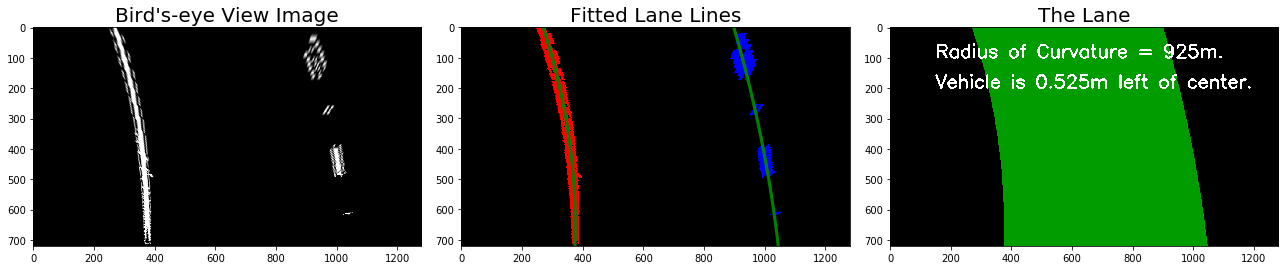

In [14]:
# verify the lane fitting routine

# set the global parameters
left_fit = None
right_fit = None
use_red_filter = True
use_prev_fit = False
prev_fit_w = 0.2

# get the test file
test_files = glob.glob('test_images/t*.jpg')
test_files = test_files[0:2]
# figure parameters
n_xsp = 1
n_ysp = 3
i_sp = 0
i_list = [1]
fig = plt.figure(num=1, figsize=(18,6))
fit_2x = True
fig_file_name = "bev_refit_images.jpg"

# figure parameters
#test_files = glob.glob('challenge_images/*.jpg')
#n_xsp = 6 #len(test_files)
#n_ysp = 3
#i_sp = 0
#n_pic = 3
#n_min = n_pic - n_xsp
#i_list = range(n_min,len(test_files)) #[0,4,7] # [0,range(0,len(test_files))]
#fig = plt.figure(num=1, figsize=(10,10))
#test_files = test_files[0:n_pic]



for i,test_file in enumerate(test_files):
    global left_fit
    global right_fit
    
    left_fit = None
    right_fit = None
    
    # read in the file
    print(test_file)
    img = cv2.imread(test_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Do camera calibration given object points and image points
    undst_img = undistort_image(img,obj_points,img_points)
    bin_img = get_binary_image(undst_img)
    
    # Get the birds-eye-view of the
    #bev_img,bev_M,pts_src,pts_dst,btm_offset = get_bev_image(bin_img,460,440,15,60.0,2)
    bev_img,bev_M,pts_src,pts_dst,btm_offset = get_bev_image(bin_img,460,440,15,60.0,2)
    
    # Convert it to gray
    left_fit, right_fit, info_fit = get_lane_fits(bev_img, left_fit, right_fit, btm_offset)
    if (fit_2x):
        left_fit, right_fit, info_fit = get_lane_fits(bev_img, left_fit, right_fit, btm_offset)
    
    ploty = info_fit['ploty']
    left_fitx = info_fit['left_fitx']
    right_fitx = info_fit['right_fitx']
    
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line =np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    pts = np.hstack((left_line, right_line))

    bev_lane_img = np.zeros(bev_img.shape)
    cv2.fillPoly(bev_lane_img, pts.astype(np.int), (0,100,0))
    
    inv_M = cv2.getPerspectiveTransform(pts_dst,pts_src)
    lane_img = cv2.warpPerspective(bev_lane_img,inv_M,(undst_img.shape[1],undst_img.shape[0]))
    
    # over lay this on the undist image.
    lane_img = cv2.addWeighted(undst_img, 1.0, lane_img.astype(np.uint8), 1.0, 0.)
        
    #avg_curve_rad = np.found(info_fit['avg_curve_rad'])
    str_curve = "Radius of Curvature = {0:.0f}m.".format(info_fit['avg_curve_rad'])
    center_offset = info_fit['center_offset']
    str_center_dir = "left"
    if (center_offset < 0):
        str_center_dir = "right"
    str_center = "Vehicle is {0:5.3f}m {1} of center.".format(np.abs(center_offset),str_center_dir)
    
    #cv2.putText(lane_img,str_curve,(100,100),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,255,255),2)
    cv2.putText(lane_img,str_curve,(150,100),cv2.FONT_HERSHEY_SIMPLEX,2.0,(255,255,255),5)
    cv2.putText(lane_img,str_center,(150,200),cv2.FONT_HERSHEY_SIMPLEX,2.0,(255,255,255),5)
    
    if i in i_list:
        # Draw the results
        blank_img = np.zeros(bev_img.shape,dtype='u1')
        blank_img[info_fit['lefty'].astype(np.int),info_fit['leftx'].astype(np.int),0] = 255
        blank_img[info_fit['righty'].astype(np.int),info_fit['rightx'].astype(np.int),2] = 255

        fits_img = cv2.cvtColor(bev_img[:,:,0].astype(np.uint8),cv2.COLOR_GRAY2RGB) 
        fits_img = cv2.addWeighted(fits_img, 1.0, blank_img, 1.0, 0.)
        
        if (not fit_2x):
            window_width = 200
            window_height = 80
            margin = 100
            gray = cv2.cvtColor(bev_img.astype(np.float32),cv2.COLOR_RGB2GRAY)  
            window_centroids = find_window_centroids(gray, window_width, window_height, margin)
            # If we found any window centers
            if len(window_centroids) > 0:
                # Points used to draw all the left and right windows
                l_points = np.zeros(gray.shape)
                r_points = np.zeros(gray.shape)

                # Go through each level and draw the windows
                for level in range(0,len(window_centroids)):
                    # Window_mask is a function to draw window areas
                    #print(window_centroids[level][0],window_centroids[level][1])
                    l_mask = window_mask(window_width,window_height,gray,window_centroids[level][0],level)
                    r_mask = window_mask(window_width,window_height,gray,window_centroids[level][1],level)
                    # Add graphic points from window mask here to total pixels found 
                    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
                    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            
                boxes = np.array(r_points+l_points,np.uint8)*.5 # add both left and right window pixels together
                zero_channel = np.zeros_like(boxes) # create a zero color channel
                boxes = np.array(cv2.merge((zero_channel,boxes,zero_channel)),np.uint8) # make window pixels green
                fits_img = cv2.addWeighted(fits_img, 1, boxes, 0.5, 0.0) # overlay the orignal road image with window results


        
        ax = fig.add_subplot(n_xsp,n_ysp,i_sp+1)
        ax.set_title("Bird's-eye View Image",fontsize=20)
        plt.imshow(bev_img)
        
        #cv2.putText(lane_img,str_curve,(100,100),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,255,255),2)
        cv2.putText(bev_lane_img,str_curve,(150,100),cv2.FONT_HERSHEY_SIMPLEX,2.0,(1,1,1),5)
        cv2.putText(bev_lane_img,str_center,(150,200),cv2.FONT_HERSHEY_SIMPLEX,2.0,(1,1,1),5)
        
        ax = fig.add_subplot(n_xsp,n_ysp,i_sp+2)
        ax.set_title("Fitted Lane Lines", fontsize=20)
        plt.imshow(fits_img)
        #plt.imshow(bev,cmap="gray")
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.xlim(0, 1280)
        plt.ylim(720, 0) 
   
        ax = fig.add_subplot(n_xsp,n_ysp,i_sp+3)  
        plt.imshow(bev_lane_img)
        #plt.imshow(lane_img)
        ax.set_title("The Lane", fontsize=20)
        i_sp += 3
        
        plt.tight_layout()
        
fig.savefig(os.path.join(output_dir,fig_file_name))
   


In [15]:
# the pipeline function
def draw_lane_on_road(img):
    global left_fit
    global right_fit
    
    # Do camera calibration given object points and image points
    undst_img = undistort_image(img,obj_points,img_points)
    bin_img = get_binary_image(undst_img)
    #plt.imshow(bin_img)
    
    # Get the birds-eye-view image
    #bev_img,bev_M,pts_src,pts_dst,btm_offset = get_bev_image(bin_img,460,440,15,60.0,2)
    bev_img,bev_M,pts_src,pts_dst,btm_offset = get_bev_image(bin_img)
    #plt.imshow(bev_img)
    
    # Convert it to gray
    left_fit, right_fit, info_fit = get_lane_fits(bev_img, left_fit, right_fit, btm_offset)
    #left_fit, right_fit, info_fit = get_lane_fits(bev_img, left_fit, right_fit, btm_offset)
    
    ploty = info_fit['ploty']
    left_fitx = info_fit['left_fitx']
    right_fitx = info_fit['right_fitx']
    
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line =np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    pts = np.hstack((left_line, right_line))

    bev_lane_img = np.zeros(bev_img.shape)
    cv2.fillPoly(bev_lane_img, pts.astype(np.int), (0,100,0))

    inv_M = cv2.getPerspectiveTransform(pts_dst,pts_src)
    lane_img = cv2.warpPerspective(bev_lane_img,inv_M,(undst_img.shape[1],undst_img.shape[0]))
    
    # over lay this on the undist image.
    lane_img = cv2.addWeighted(undst_img, 1.0, lane_img.astype(np.uint8), 1.0, 0.)
        
    str_curve = "Radius of Curvature = {0:.0f}m.".format(info_fit['avg_curve_rad'])
    center_offset = info_fit['center_offset']
    str_center_dir = "left"
    if (center_offset < 0):
        str_center_dir = "right"
    str_center = "Vehicle is {0:5.3f}m {1} of center.".format(np.abs(center_offset),str_center_dir)
    
    cv2.putText(lane_img,str_curve,(250,75),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)
    cv2.putText(lane_img,str_center,(250,150),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)
   
    lane_img = lane_img.astype(np.uint8)
    
    return lane_img #,bin_img,bev_img

test_images\straight_lines1.jpg
test_images\straight_lines2.jpg
test_images\test1.jpg
test_images\test2.jpg
test_images\test3.jpg
test_images\test4.jpg
test_images\test5.jpg
test_images\test6.jpg


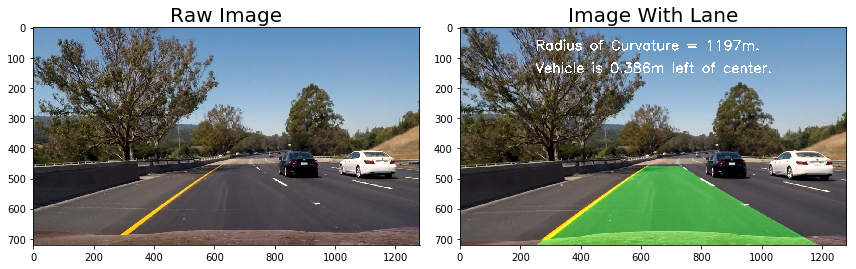

In [16]:
# check that all test images look reasonable
fig = plt.figure(num=1, figsize=(12,4))

left_fit = None
right_fit = None

test_files = glob.glob('test_images/*.jpg')
for i,test_file in enumerate(test_files):
    
    print(test_file)
        
    img = cv2.imread(test_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for k in range(0,4):
        lane_img = draw_lane_on_road(img)
    
    lane_file = os.path.basename(test_file)
    lane_file = lane_file[:-4] + 'wlane.jpg' 

    ax = fig.add_subplot(1,2,1)
    ax.set_title('Raw Image', fontsize=20)
    plt.imshow(img)
    
    ax = fig.add_subplot(1,2,2)
    ax.set_title("Image With Lane", fontsize=20)
    plt.imshow(lane_img)

    plt.tight_layout()

    fig.savefig(os.path.join(output_dir,lane_file))
        
                   

## Test on Videos
Test the solution on the provided videos:

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def process_image(image):
    global i
    
    if i == 0:
        lane_img = draw_lane_on_road(image) #,left_fit,right_fit)
    lane_img = draw_lane_on_road(image)
    

    #save an image from a subclip
    #output_dir = "challenge_images"
    #si = "{0:03d}".format(i)
    #mpimg.imsave(os.path.join(output_dir,"chal"+si+".jpg"),image)
    
    i += 1
    
    return lane_img

In [19]:
global i

i = 0
left_fit = None
right_fit = None
use_red_filter = True
use_prev_fit = True
prev_fit_w = 1

In [20]:
project_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(20,25)
#clip1 = VideoFileClip("project_video.mp4").subclip(39,42)
#clip1 = VideoFileClip("project_video.mp4").subclip(35,39)
clip1 = VideoFileClip("project_video.mp4")
#project_clip = clip1.fx(test_image,4) #NOTE: this function expects color images!!
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [25:43<00:01,  1.16s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 25min 45s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [22]:
i = 0
left_fit = None
right_fit = None
#use_red_filter = True
#use_prev_fit = True
#prev_fit_w = 1.

In [23]:
challenge_output = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,10)
clip1 = VideoFileClip("challenge_video.mp4")
#project_clip = clip1.fx(test_image,4) #NOTE: this function expects color images!!
challenge_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [09:04<00:00,  1.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 9min 6s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))